1️⃣ DCGAN: Why Do We Need It?
Problems with Vanilla GAN:
Fully connected layers struggle to capture spatial features of images.

Poor quality outputs (artifacts, blurry images).

Mode collapse (generator produces very similar outputs).

DCGAN Improvements:
✅ Uses CNNs instead of MLPs, improving image quality.
✅ Introduces BatchNorm to stabilize training.
✅ Uses LeakyReLU in Discriminator instead of standard ReLU.
✅ Uses Strided Convolutions instead of Pooling layers.



2️⃣ DCGAN Architecture
💡 Main changes compared to Vanilla GAN:

Generator:

Uses transposed convolutions (ConvTranspose2D) for upsampling.

BatchNorm added after each layer (except last).

Uses ReLU activation (except last layer uses Tanh).

Discriminator:

Uses strided convolutions (Conv2D with stride) instead of pooling.

LeakyReLU instead of ReLU (helps prevent dead neurons).

No max-pooling (preserves spatial features).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
learning_rate = 0.0002
latent_dim = 100
epochs = 50
image_size = 64  # DCGAN uses 64x64 images instead of 28x28


In [2]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load dataset
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:10<00:00, 905kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.99MB/s]


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent_dim (100) → 1024x4x4 feature map
            nn.ConvTranspose2d(latent_dim, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            # 1024x4x4 → 512x8x8
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            # 512x8x8 → 256x16x16
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # 256x16x16 → 128x32x32
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 128x32x32 → 1x64x64 (Grayscale output)
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

# Initialize Generator
generator = Generator().to(device)


In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # 1x64x64 → 128x32x32
            nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),

            # 128x32x32 → 256x16x16
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            # 256x16x16 → 512x8x8
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            # 512x8x8 → 1024x4x4
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),

            # 1024x4x4 → 1 (Output probability)
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)

# Initialize Discriminator
discriminator = Discriminator().to(device)


In [5]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


Epoch [0/50] Batch 0/469 | D Loss: 1.4436 | G Loss: 4.4135
Epoch [0/50] Batch 200/469 | D Loss: 0.0008 | G Loss: 8.5104
Epoch [0/50] Batch 400/469 | D Loss: 0.9285 | G Loss: 0.6398


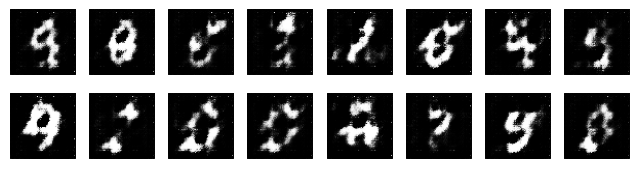

Epoch [1/50] Batch 0/469 | D Loss: 1.0402 | G Loss: 3.5368
Epoch [1/50] Batch 200/469 | D Loss: 0.7902 | G Loss: 1.3782
Epoch [1/50] Batch 400/469 | D Loss: 2.1546 | G Loss: 0.5029


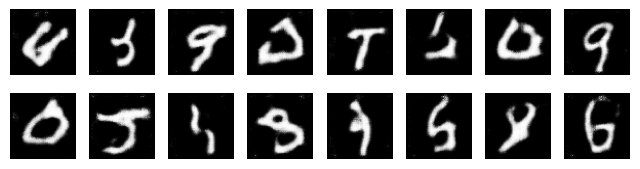

Epoch [2/50] Batch 0/469 | D Loss: 1.3787 | G Loss: 0.6786
Epoch [2/50] Batch 200/469 | D Loss: 1.0951 | G Loss: 3.3630
Epoch [2/50] Batch 400/469 | D Loss: 1.2131 | G Loss: 3.8087


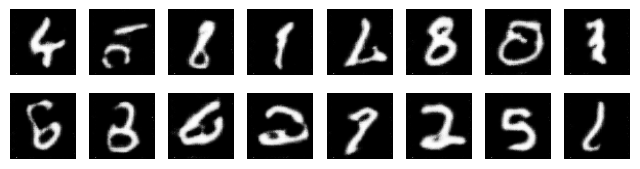

Epoch [3/50] Batch 0/469 | D Loss: 0.6850 | G Loss: 2.3968
Epoch [3/50] Batch 200/469 | D Loss: 0.2733 | G Loss: 2.9145
Epoch [3/50] Batch 400/469 | D Loss: 1.1358 | G Loss: 1.2635


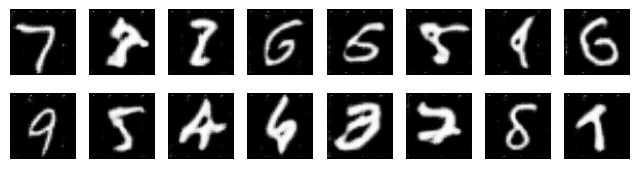

Epoch [4/50] Batch 0/469 | D Loss: 0.2443 | G Loss: 5.8116
Epoch [4/50] Batch 200/469 | D Loss: 0.0346 | G Loss: 7.2927
Epoch [4/50] Batch 400/469 | D Loss: 0.0018 | G Loss: 7.5624


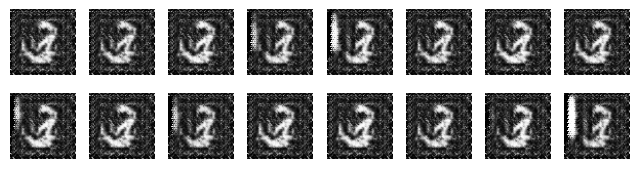

Epoch [5/50] Batch 0/469 | D Loss: 0.0018 | G Loss: 7.7477
Epoch [5/50] Batch 200/469 | D Loss: 0.3816 | G Loss: 4.0264
Epoch [5/50] Batch 400/469 | D Loss: 0.4237 | G Loss: 3.7730


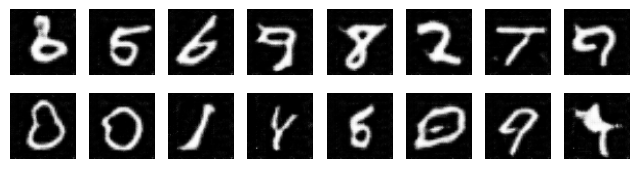

Epoch [6/50] Batch 0/469 | D Loss: 0.5126 | G Loss: 1.7143
Epoch [6/50] Batch 200/469 | D Loss: 0.5845 | G Loss: 2.2915
Epoch [6/50] Batch 400/469 | D Loss: 0.1265 | G Loss: 4.3413


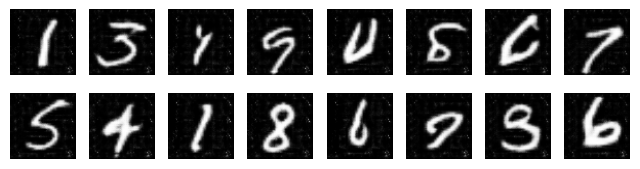

Epoch [7/50] Batch 0/469 | D Loss: 0.2247 | G Loss: 4.9938
Epoch [7/50] Batch 200/469 | D Loss: 0.3165 | G Loss: 3.1339
Epoch [7/50] Batch 400/469 | D Loss: 0.3000 | G Loss: 4.0642


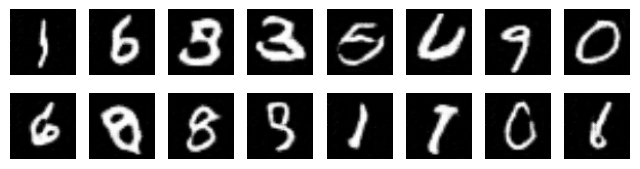

Epoch [8/50] Batch 0/469 | D Loss: 0.1850 | G Loss: 3.3606
Epoch [8/50] Batch 200/469 | D Loss: 0.0076 | G Loss: 7.0376
Epoch [8/50] Batch 400/469 | D Loss: 0.0021 | G Loss: 10.7234


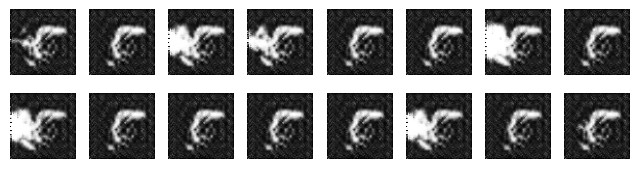

In [ ]:
import numpy as np

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Generate noise and create fake images
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(z)

        # ---- Train Discriminator ----
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_loss = criterion(discriminator(real_images), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # ---- Train Generator ----
        g_loss = criterion(discriminator(fake_images), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if i % 200 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {i}/{len(dataloader)} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

    # Save generated images
    with torch.no_grad():
        test_z = torch.randn(16, latent_dim, 1, 1).to(device)
        generated = generator(test_z).cpu().numpy()
        fig, axes = plt.subplots(2, 8, figsize=(8, 2))
        for ax, img in zip(axes.flatten(), generated):
            ax.imshow(img.squeeze(), cmap="gray")
            ax.axis("off")
        plt.show()
